# DeepHyper/Hyperparameter Search

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deephyper/anl-22-summer-workshop/blob/main/notebooks/1-Hyperparameter-Search.ipynb)

Developing surrogate geophysical models from data is a key research topic in atmospheric and oceanic modeling because of the large computational costs associated with numerical simulation methods. Researchers have started applying a wide range of machine learning models, in particular neural networks, to geophysical data for forecasting without these constraints. Constructing neural networks for forecasting such data is nontrivial, however, and often requires trial and error. 

We focus on a particularly promising approach for nonintrusive modeling (or forecasting) involving the use of linear
dimensionality reduction followed by recurrent neural network time evolution. This forecast technique compresses the spatiotemporal field into its dominant principal components by using proper orthogonal decomposition (POD) (also known as principal components analysis). Following this, the coefficients of each component are evolved by using a time series method. In recent literature, long short-term memory networks (LSTMs), a variant of recurrent neural networks, have been used extensively for modeling temporally varying POD coefficients. The construction of an LSTM architecture for this purpose is generally based on trial and error, requires human expertise, and consumes significant development time. For more details see [1].

[1] R. Maulik, R. Egele, B. Lusch, and P. Balaprakash. "Recurrent neural network architecture search for geophysical emulation." In SC20: International Conference for High Performance Computing, Networking, Storage and Analysis, pp. 1-14. IEEE, 2020. https://arxiv.org/abs/2004.10928

In this notebook, we will start with a manually designed simple POD-LSTM and show how to improve its accuracy using DeepHyper's hyperparameter search.

In [1]:
# Test if notebook is executed from Google Colab
IN_COLAB = False
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
print("In Colab:", IN_COLAB)

# Install dependencies if running in google collab
if IN_COLAB:
    !pip install deephyper
    !pip install matplotlib==3.5.2
    !git clone https://github.com/deephyper/anl-22-summer-workshop.git

# Download the data if running in google collab
if IN_COLAB:
    %cd /content/anl-22-summer-workshop/data
    !gdown 1J4kU3j49B9xWRpALgr8d90BjJCnwhAOS
    !gdown 1fuHM93OUcu536Ux6p2Oandbi3BrGl8vh
    !gdown 1fXHrFpM21LMUFj-S7jXLI4yZcJi3oAaU

In Colab: True
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'anl-22-summer-workshop' already exists and is not an empty directory.
/content/anl-22-summer-workshop/notebooks/data
Downloading...
From: https://drive.google.com/uc?id=1J4kU3j49B9xWRpALgr8d90BjJCnwhAOS
To: /content/anl-22-summer-workshop/notebooks/data/mask.npy
100% 195k/195k [00:00<00:00, 51.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fuHM93OUcu536Ux6p2Oandbi3BrGl8vh
To: /content/anl-22-summer-workshop/notebooks/data/sst_var_test.npy
100% 661M/661M [00:04<00:00, 150MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fXHrFpM21LMUFj-S7jXLI4yZcJi3oAaU
To: /content/anl-22-summer-workshop/notebooks/data/sst_var_train.npy
100% 190M/190M [00:00<00:00, 224MB/s]


**If running in Google Colab, restart the runtime to load installed packages**. You can also ask for a TPU (the LSTM layer used is not cuda compatible).

* `Runtime > Change runtime type (select TPU)`
* `Runtime > Restart runtime`

In [1]:
# Test if notebook is executed from Google Colab
IN_COLAB = False
try:
      import google.colab
      IN_COLAB = True
except:
      IN_COLAB = False
print("In Colab:", IN_COLAB)

if not(IN_COLAB):
    import os
    root_dir = os.path.dirname(os.getcwd())
    %cd $root_dir

import gzip

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from data.utils import load_sst_data, load_data_prepared
from sklearn.decomposition import PCA

from deephyper.nas.metrics import r2, mse


In Colab: False


## Loading sea surface temperature data set
Load the data with shape `(timestep, latitude, longitude)` containing temperature with Celsius as unit; each time step is a weekly average

In [2]:
train_data, test_data, mask = load_sst_data()
# training data
print(train_data.shape)
# test data
print(test_data.shape)
# mask to hide the land surface; we are not forecasting the temperature on land
print(mask.shape) 

(427, 180, 360)
(1487, 180, 360)
(1, 180, 360)


## Vizualizing sea surface temperature data set
We can visualize the first week temperature data as follows

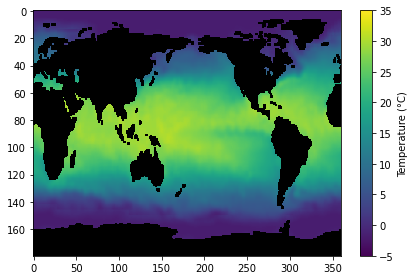

In [3]:
palette = plt.cm.viridis.with_extremes(over='r', under='r', bad='black')

idx = 0
snapshot = train_data[idx].copy()
snapshot[np.where(mask[0] == 0)] = 100
snapshot_masked = np.ma.masked_where(snapshot == 100, snapshot)


plt.figure()
im = plt.imshow(snapshot_masked, cmap=palette, vmin=-5,vmax=35, aspect="auto")
plt.colorbar(im, label="Temperature (°C)")
plt.tight_layout()
plt.show()

## Dimensionality reduction
Perform a simple dimensionality reduction with Principal Component Analysis (PCA aka POD)

In [4]:
n_components = 5
pca = PCA(n_components=n_components)


# flatten the data
train_data_flat = train_data.reshape(train_data.shape[0], -1)
test_data_flat = test_data.reshape(test_data.shape[0], -1)

train_data_reduc = pca.fit_transform(train_data_flat)
test_data_reduc = pca.transform(test_data_flat)

explained_variance_ratio = pca.explained_variance_ratio_.cumsum()[-1]
print(f"{explained_variance_ratio*100:.2f} % with {n_components} component(s)")

93.34 % with 5 component(s)


## Vizualize the original data and the reconstructed data 

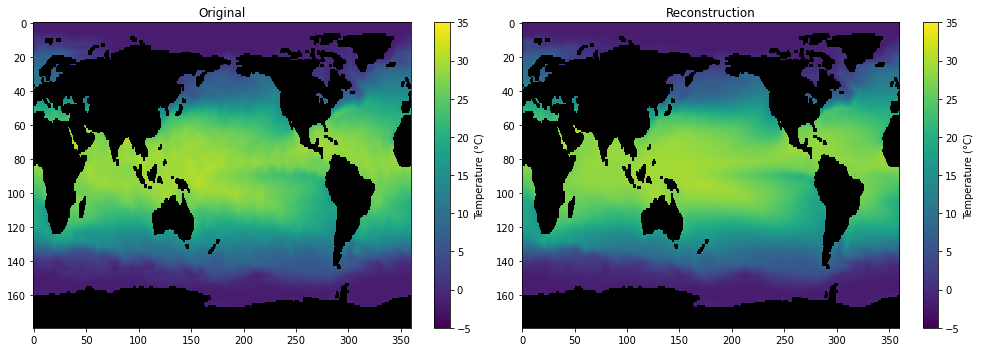

In [5]:
idx = 0
snapshot = train_data[idx].copy()
snapshot[np.where(mask[0] == 0)] = 100
snapshot_masked_full = np.ma.masked_where(snapshot == 100, snapshot)

inv_train_data_reduc = pca.inverse_transform(train_data_reduc[idx])
snapshot = inv_train_data_reduc.copy().reshape(train_data.shape[1:])
snapshot[np.where(mask[0] == 0)] = 100
snapshot_masked_redu = np.ma.masked_where(snapshot == 100, snapshot)


plt.figure(figsize=(14, 5))
ax = plt.subplot(1, 2, 1)
ax.set_title("Original")
im = plt.imshow(snapshot_masked_full, cmap=palette, vmin=-5,vmax=35, aspect="auto")
plt.colorbar(im, label="Temperature (°C)")
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
ax.set_title("Reconstruction")

im = plt.imshow(snapshot_masked_redu, cmap=palette, vmin=-5,vmax=35, aspect="auto")
plt.colorbar(im, label="Temperature (°C)")
plt.tight_layout()
plt.show()

## Baseline LSTM Model

In [6]:
def build_and_train_model(config: dict, n_components: int = 5, verbose: bool = 0):
    tf.keras.utils.set_random_seed(42)

    default_config = {
        "lstm_units": 128,
        "activation": "tanh",
        "recurrent_activation": "sigmoid",
        "learning_rate": 1e-3,
        "batch_size": 64,
        "dropout_rate": 0,
        "num_layers": 1,
        "epochs": 20,
    }
    default_config.update(config)

    (X_train, y_train), (X_valid, y_valid), _, _ = load_data_prepared(
        n_components=n_components
    )

    layers = []
    for _ in range(default_config["num_layers"]):
        lstm_layer = tf.keras.layers.LSTM(
            default_config["lstm_units"],
            activation=default_config["activation"],
            recurrent_activation=default_config["recurrent_activation"],
            return_sequences=True,
        )
        dropout_layer = tf.keras.layers.Dropout(default_config["dropout_rate"])
        layers.extend([lstm_layer, dropout_layer])

    model = tf.keras.Sequential(
        [tf.keras.Input(shape=X_train.shape[1:])]
        + layers
        + [tf.keras.layers.Dense(n_components)]
    )

    if verbose:
        model.summary()

    optimizer = tf.keras.optimizers.Adam(learning_rate=default_config["learning_rate"])
    model.compile(optimizer, "mse", metrics=[])

    history = model.fit(
        X_train,
        y_train,
        epochs=default_config["epochs"],
        batch_size=default_config["batch_size"],
        validation_data=(X_valid, y_valid),
        verbose=verbose,
    ).history

    return model, history


In [7]:
n_components = 5

model, history = build_and_train_model(config={}, n_components=n_components, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8, 128)            68608     
                                                                 
 dropout (Dropout)           (None, 8, 128)            0         
                                                                 
 dense (Dense)               (None, 8, 5)              645       
                                                                 
Total params: 69,253
Trainable params: 69,253
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


2022-07-12 10:18:15.085797: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


14/14 [==============================] - 1s 21ms/step - loss: 0.1763 - val_loss: 0.1014
Epoch 2/20
14/14 [==============================] - 0s 7ms/step - loss: 0.0855 - val_loss: 0.0696
Epoch 3/20
14/14 [==============================] - 0s 7ms/step - loss: 0.0602 - val_loss: 0.0499
Epoch 4/20
14/14 [==============================] - 0s 7ms/step - loss: 0.0447 - val_loss: 0.0397
Epoch 5/20
14/14 [==============================] - 0s 7ms/step - loss: 0.0372 - val_loss: 0.0338
Epoch 6/20
14/14 [==============================] - 0s 7ms/step - loss: 0.0322 - val_loss: 0.0298
Epoch 7/20
14/14 [==============================] - 0s 7ms/step - loss: 0.0287 - val_loss: 0.0266
Epoch 8/20
14/14 [==============================] - 0s 7ms/step - loss: 0.0257 - val_loss: 0.0240
Epoch 9/20
14/14 [==============================] - 0s 7ms/step - loss: 0.0232 - val_loss: 0.0220
Epoch 10/20
14/14 [==============================] - 0s 7ms/step - loss: 0.0212 - val_loss: 0.0200
Epoch 11/20
14/14 [==========

# Vizualize the learning curves of this baseline

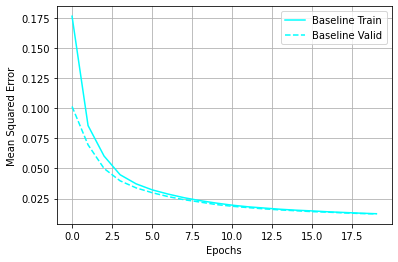

In [8]:
plt.figure()
plt.plot(history["loss"], color="cyan", linestyle="-", label="Baseline Train")
plt.plot(history["val_loss"], color="cyan", linestyle="--", label="Baseline Valid")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.grid()
plt.legend()
plt.show()

In [9]:
cached_data = f"processed_data_{n_components}_8_8.npz"
with gzip.GzipFile(cached_data, "rb") as f:
    data = np.load(f, allow_pickle=True).item()
    X_train, y_train = data["train"]
    X_valid, y_valid = data["valid"]
    X_test, y_test = data["test"]
    preprocessor = data["preprocessor"]

y_pred = model.predict(X_train)
shape = y_pred.shape
y_pred = y_pred.reshape(-1, shape[-1])
y_pred = preprocessor.inverse_transform(y_pred).reshape((*shape[:2], -1))

# Vizualize the forecasts

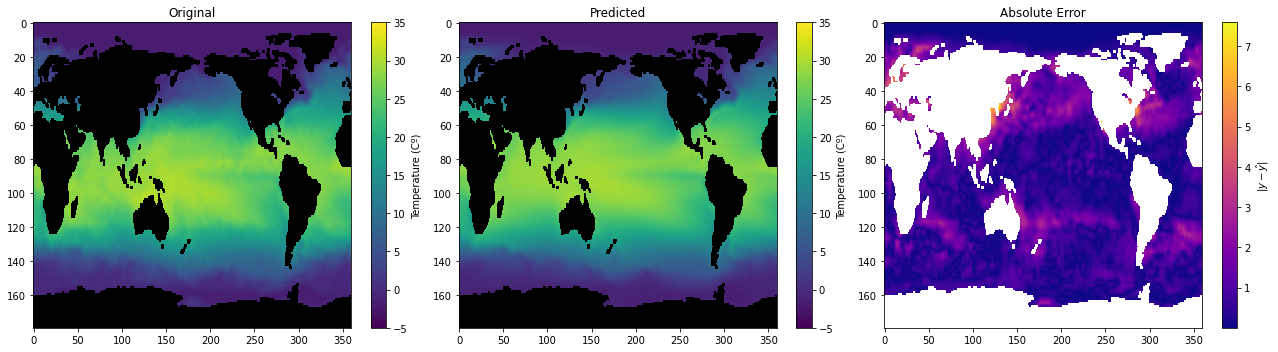

In [10]:
idx = 9 # should be > than input_horizon!
snapshot = train_data[idx].copy()
snapshot[np.where(mask[0] == 0)] = 100
snapshot_masked_full = np.ma.masked_where(snapshot == 100, snapshot)

input_horizon = X_train.shape[1]
inv_y_pred = y_pred[idx-input_horizon][0].reshape(train_data.shape[1:])
snapshot = inv_y_pred.copy()
snapshot[np.where(mask[0] == 0)] = 100
snapshot_masked_redu = np.ma.masked_where(snapshot == 100, snapshot)

plt.figure(figsize=(18, 5))
ax = plt.subplot(1, 3, 1)
ax.set_title("Original")
im = plt.imshow(snapshot_masked_full, cmap=palette, vmin=-5,vmax=35, aspect="auto")
plt.colorbar(im, label="Temperature (Cº)")
plt.tight_layout()

ax = plt.subplot(1, 3, 2)
ax.set_title("Predicted")

im = plt.imshow(snapshot_masked_redu, cmap=palette, vmin=-5,vmax=35, aspect="auto")
plt.colorbar(im, label="Temperature (Cº)")
plt.tight_layout()

ax = plt.subplot(1, 3, 3)
ax.set_title("Absolute Error")
err = np.abs(snapshot_masked_full - snapshot_masked_redu)
im = plt.imshow(err, cmap="plasma", aspect="auto")
plt.colorbar(im, label="$|y - \hat{y}|$")
plt.tight_layout()

plt.show()

In [11]:
scores = {"MSE": mse, "R2": r2}

for metric_name, metric_func in scores.items():
    print(f"Metric {metric_name}")
    y_pred = model.predict(X_train)
    score_train = np.mean(metric_func(y_train, y_pred).numpy())

    y_pred = model.predict(X_valid)
    score_valid = np.mean(metric_func(y_valid, y_pred).numpy())

    y_pred = model.predict(X_test)
    score_test = np.mean(metric_func(y_test, y_pred).numpy())

    print(f"train: {score_train:.4f}")
    print(f"valid: {score_valid:.4f}")
    print(f"test : {score_test:.4f}")
    print()

Metric MSE
train: 0.0122
valid: 0.0122
test : 0.0177

Metric R2
train: 0.7545
valid: 0.7576
test : 0.6415



## Hyperparameter optimization with DeepHyper
Hyperparameter search space definition

In [12]:
from deephyper.problem import HpProblem


problem = HpProblem()
problem.add_hyperparameter((10, 256), "units", default_value=128)
problem.add_hyperparameter(["sigmoid", "tanh", "relu"], "activation", default_value="tanh")
problem.add_hyperparameter(["sigmoid", "tanh", "relu"], "recurrent_activation", default_value="sigmoid")
problem.add_hyperparameter((1e-5, 1e-2, "log-uniform"), "learning_rate", default_value=1e-3)
problem.add_hyperparameter((2, 64), "batch_size", default_value=64)
problem.add_hyperparameter((0.0, 0.5), "dropout_rate", default_value=0.0)
problem.add_hyperparameter((1, 3), "num_layers", default_value=1)
problem.add_hyperparameter((10, 100), "epochs", default_value=20)
problem

Configuration space object:
  Hyperparameters:
    activation, Type: Categorical, Choices: {sigmoid, tanh, relu}, Default: tanh
    batch_size, Type: UniformInteger, Range: [2, 64], Default: 64
    dropout_rate, Type: UniformFloat, Range: [0.0, 0.5], Default: 0.0
    epochs, Type: UniformInteger, Range: [10, 100], Default: 20
    learning_rate, Type: UniformFloat, Range: [1e-05, 0.01], Default: 0.001, on log-scale
    num_layers, Type: UniformInteger, Range: [1, 3], Default: 1
    recurrent_activation, Type: Categorical, Choices: {sigmoid, tanh, relu}, Default: sigmoid
    units, Type: UniformInteger, Range: [10, 256], Default: 128

Definition of the function to optimize (configurable model to train)

In [13]:
def run(config):
    # important to avoid memory exploision
    tf.keras.backend.clear_session()
    
    _, history = build_and_train_model(config, n_components=n_components, verbose=0)

    return -history["val_loss"][-1]

Execution of a sequential Bayesian optimization search

In [14]:
from deephyper.search.hps import CBO

search = CBO(problem, run, initial_points=[problem.default_configuration], log_dir="cbo-results", random_state=42)
results = search.search(max_evals=20)

/Users/romainegele/Documents/Argonne/deephyper/deephyper/evaluator/_evaluator.py:101: UserWarning: Applying nest-asyncio patch for IPython Shell!
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

In [15]:
results

,activation,batch_size,dropout_rate,epochs,learning_rate,num_layers,recurrent_activation,units,job_id,objective,timestamp_submit,timestamp_gather
0,tanh,64,0.000000,20,0.001000,1,sigmoid,128,1,-0.012235,0.026298,2.840285
1,tanh,44,0.447781,84,0.002855,3,sigmoid,200,2,-0.003322,2.920337,38.213056
2,sigmoid,54,0.413658,60,0.000013,2,tanh,10,3,-0.064103,38.253595,53.113675
3,relu,2,0.417985,75,0.000177,3,tanh,100,4,-0.064214,53.153503,302.623374
4,tanh,41,0.001076,19,0.000033,1,relu,216,5,-0.230617,302.665584,305.290451
5,tanh,10,0.257901,85,0.002256,1,sigmoid,234,6,-0.002828,305.330441,329.466668
6,tanh,13,0.488280,73,0.000286,3,relu,141,7,-0.064218,329.506964,393.962728
7,tanh,53,0.493778,91,0.003269,2,sigmoid,111,8,-0.003594,394.002130,417.070507
8,sigmoid,48,0.222868,40,0.000020,2,tanh,91,9,-0.057260,417.110327,428.275146
9,relu,43,0.165007,46,0.002653,3,tanh,19,10,-0.064219,428.315161,448.151982


In [16]:
def filter_failures(df):
    if df.objective.dtype != np.float64:
        df = df[~df.objective.str.startswith("F")]
        df = df.astype({"objective": float})
    return df

results = filter_failures(results)

i_max = results.objective.argmax()
best_config = results.iloc[i_max][:-4].to_dict()
best_config

{'activation': 'tanh',
 'batch_size': 50,
 'dropout_rate': 0.1136473557998453,
 'epochs': 97,
 'learning_rate': 0.0045239394335205,
 'num_layers': 1,
 'recurrent_activation': 'relu',
 'units': 243}

In [17]:
best_model, best_history = build_and_train_model(best_config, n_components=n_components, verbose=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 8, 128)            68608     
                                                                 
 dropout_1 (Dropout)         (None, 8, 128)            0         
                                                                 
 dense_1 (Dense)             (None, 8, 5)              645       
                                                                 
Total params: 69,253
Trainable params: 69,253
Non-trainable params: 0
_________________________________________________________________
Epoch 1/97
18/18 [==============================] - 1s 11ms/step - loss: 0.1899 - val_loss: 0.1102
Epoch 2/97
18/18 [==============================] - 0s 6ms/step - loss: 0.0682 - val_loss: 0.0327
Epoch 3/97
18/18 [==============================] - 0s 6ms/step - loss: 0.0263 - val_loss: 0.0174
Epoch 4/97
18/18 [=

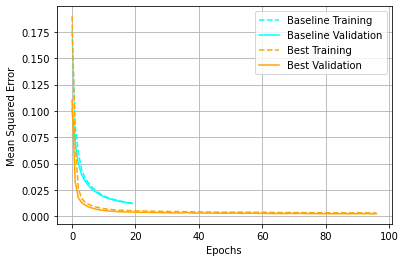

In [18]:
plt.figure()

plt.plot(history["loss"], color="cyan", linestyle="--", label="Baseline Training")
plt.plot(history["val_loss"], color="cyan", linestyle="-", label="Baseline Validation")

plt.plot(best_history["loss"], color="orange", linestyle="--", label="Best Training")
plt.plot(best_history["val_loss"], color="orange", linestyle="-", label="Best Validation")

plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.grid()
plt.legend()
plt.show()

In [19]:
y_pred_best =  best_model.predict(X_train)
shape = y_pred_best.shape
y_pred_best = y_pred_best.reshape(-1, shape[-1])
y_pred_best = preprocessor.inverse_transform(y_pred_best).reshape((*shape[:2], -1))

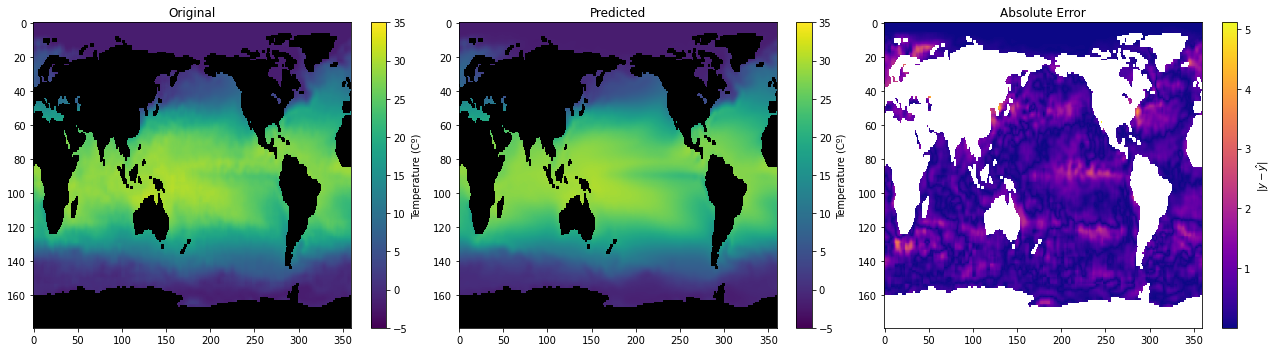

In [20]:
idx = 9 # should be > than input_horizon!
snapshot = train_data[idx].copy()
snapshot[np.where(mask[0] == 0)] = 100
snapshot_masked_full = np.ma.masked_where(snapshot == 100, snapshot)

input_horizon = X_train.shape[1]
inv_y_pred = y_pred_best[idx-input_horizon][0].reshape(train_data.shape[1:])
snapshot = inv_y_pred.copy()
snapshot[np.where(mask[0] == 0)] = 100
snapshot_masked_redu = np.ma.masked_where(snapshot == 100, snapshot)


plt.figure(figsize=(18, 5))
ax = plt.subplot(1, 3, 1)
ax.set_title("Original")
im = plt.imshow(snapshot_masked_full, cmap=palette, vmin=-5,vmax=35, aspect="auto")
plt.colorbar(im, label="Temperature (Cº)")
plt.tight_layout()

ax = plt.subplot(1, 3, 2)
ax.set_title("Predicted")

im = plt.imshow(snapshot_masked_redu, cmap=palette, vmin=-5,vmax=35, aspect="auto")
plt.colorbar(im, label="Temperature (Cº)")
plt.tight_layout()

ax = plt.subplot(1, 3, 3)
ax.set_title("Absolute Error")
err = np.abs(snapshot_masked_full - snapshot_masked_redu)
im = plt.imshow(err, cmap="plasma", aspect="auto")
plt.colorbar(im, label="$|y - \hat{y}|$")
plt.tight_layout()

plt.show()

In [21]:
scores = {"MSE": mse, "R2": r2}

for metric_name, metric_func in scores.items():
    print(f"Metric {metric_name}")
    y_pred = best_model.predict(X_train)
    score_train = np.mean(metric_func(y_train, y_pred).numpy())

    y_pred = best_model.predict(X_valid)
    score_valid = np.mean(metric_func(y_valid, y_pred).numpy())

    y_pred = best_model.predict(X_test)
    score_test = np.mean(metric_func(y_test, y_pred).numpy())

    print(f"train: {score_train:.4f}")
    print(f"valid: {score_valid:.4f}")
    print(f"test : {score_test:.4f}")
    print()

Metric MSE
train: 0.0021
valid: 0.0024
test : 0.0042

Metric R2
train: 0.9528
valid: 0.9475
test : 0.8926



## Restarting from Checkpoints

During a search, results are checkpointed regularly inside a `{log_dir}/results.csv` file. This file can be re-loaded and infered at the start of a new search to continue the search from it instead of restarting from zero.

In [22]:
search = CBO(problem, run, log_dir="cbo-chkpt-results", random_state=42)

# Load and infer the checkpoint for the new search
search.fit_surrogate("cbo-results/results.csv")

# Continue the search
results = search.search(max_evals=10)

/Users/romainegele/Documents/Argonne/deephyper/deephyper/evaluator/_evaluator.py:101: UserWarning: Applying nest-asyncio patch for IPython Shell!
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

In [23]:
results

,activation,batch_size,dropout_rate,epochs,learning_rate,num_layers,recurrent_activation,units,job_id,objective,timestamp_submit,timestamp_gather
0,tanh,40,0.006535,19,0.000285,1,relu,186,1,-0.020036,0.429116,3.234394
1,tanh,22,0.007790,17,0.000166,1,relu,251,2,-0.022886,3.587138,6.900779
2,tanh,31,0.002827,14,0.000414,1,relu,216,3,-0.014536,7.238060,9.857398
3,tanh,59,0.003187,21,0.000282,2,relu,217,4,-0.040453,10.193009,15.645377
4,tanh,36,0.003885,43,0.000021,1,relu,218,5,-0.166631,15.981945,21.726182
5,tanh,42,0.291394,18,0.000037,1,relu,251,6,-0.227701,22.064658,24.521901
6,tanh,44,0.310691,26,0.003716,1,relu,230,7,-0.003994,24.864317,28.204823
7,tanh,13,0.278562,16,0.000093,1,relu,207,8,-0.031873,28.683655,33.089056
8,tanh,47,0.365148,39,0.000830,1,relu,256,9,-0.005208,33.437694,38.329203
9,tanh,5,0.354900,31,0.000033,1,relu,238,10,-0.022892,38.678701,53.598721
